In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def smooth(fonctions, bornes, precision=10):
    """
    Crée une fonction lisse par transition sigmoïdale entre plusieurs fonctions définies sur des intervalles.
    
    :param precision: Contrôle la raideur des transitions (plus grand = plus raide)
    :param fonctions: Liste de fonctions à appliquer sur les intervalles
    :param bornes: Liste de bornes de transition (len(bornes) == len(fonctions) - 1)
    :return: Une fonction Python unique f(x) lisse
    """
    assert len(fonctions) == len(bornes) + 1, "Il doit y avoir une fonction de plus que de bornes."

    def sigma(x, a):
        """Sigmoïde centrée en a, de pente 'precision'"""
        return 1 / (1 + np.exp(-precision * (x - a)))

    def f(x):
        x = np.asarray(x)
        result = fonctions[0](x) * (1 - sigma(x, bornes[0]))
        for i in range(1, len(fonctions) - 1):
            s1 = sigma(x, bornes[i - 1])
            s2 = 1 - sigma(x, bornes[i])
            result += fonctions[i](x) * s1 * s2
        result += fonctions[-1](x) * sigma(x, bornes[-1])
        return result

    return f

def smooth2D(precision, fonctions, bornes, axe="x"):
    """
    Crée une fonction 2D lissée à partir de fonctions de surface et de bornes sur x ou y.

    :param precision: raideur des transitions sigmoïdales
    :param fonctions: liste de fonctions f(x, y)
    :param bornes: liste de valeurs de transition (longueur = len(fonctions) - 1)
    :param axe: "x" ou "y" pour indiquer l'axe de découpe
    :return: fonction lisse f(x, y)
    """
    assert len(fonctions) == len(bornes) + 1, "Il doit y avoir une fonction de plus que de bornes."
    assert axe in ("x", "y"), "axe doit être 'x' ou 'y'"

    def sigma(t, a):
        return 1 / (1 + np.exp(-precision * (t - a)))

    def f(x, y):
        t = x if axe == "x" else y
        result = fonctions[0](x, y) * (1 - sigma(t, bornes[0]))
        for i in range(1, len(fonctions) - 1):
            s1 = sigma(t, bornes[i - 1])
            s2 = 1 - sigma(t, bornes[i])
            result += fonctions[i](x, y) * s1 * s2
        result += fonctions[-1](x, y) * sigma(t, bornes[-1])
        return result

    return f

def smooth2Dxy(precision, fonctions_x, bornes_x, fonctions_y, bornes_y):
    """
    Crée une fonction 2D lissée selon x ET y à partir de deux listes de fonctions.
    
    Chaque direction (x et y) a ses propres fonctions et bornes.
    Le résultat est une somme pondérée croisée : f(x, y) = fx(x, y) * fy(x, y)

    :param precision: pente des sigmoïdes
    :param fonctions_x: liste de fonctions (x, y) à appliquer selon x
    :param bornes_x: bornes de transition selon x (len = len(fonctions_x) - 1)
    :param fonctions_y: idem pour y
    :param bornes_y: idem
    :return: fonction f(x, y)
    """
    def sigma(t, a):
        return 1 / (1 + np.exp(-precision * (t - a)))

    def blend(fonctions, bornes, t, x, y):
        result = fonctions[0](x, y) * (1 - sigma(t, bornes[0]))
        for i in range(1, len(fonctions) - 1):
            s1 = sigma(t, bornes[i - 1])
            s2 = 1 - sigma(t, bornes[i])
            result += fonctions[i](x, y) * s1 * s2
        result += fonctions[-1](x, y) * sigma(t, bornes[-1])
        return result

    def f(x, y):
        fx = blend(fonctions_x, bornes_x, x, x, y)
        fy = blend(fonctions_y, bornes_y, y, x, y)
        return fx + fy  # ou fx * fy interaction multiplicative

    return f

In [3]:
f1 = lambda x: np.sin(x) * 0.5
f2 = lambda x: x * 0.2
f3 = lambda x: np.cos(x + 1)
f = smooth([f1, f2, f3], [-1, 1])
x = np.linspace(-5, 10, 1000)
y = f(x)

f1_2d = lambda x, y: np.sin(x) * 0.5
f2_2d = lambda x, y: x * y * 0.2
f3_2d = lambda x, y: np.cos(x + y)
f_2d = smooth2D(precision=10, fonctions=[f1_2d, f2_2d, f3_2d], bornes=[-1, 1], axe="x")

fx1 = lambda x, y: np.sin(x) * 0.5
fx2 = lambda x, y: x * y * 0.2
fx3 = lambda x, y: np.cos(x + y)
fy1 = lambda x, y: np.sin(y) * 0.3
fy2 = lambda x, y: y**2 * 0.1
fy3 = lambda x, y: np.exp(-x**2 - y**2)
f_2dxy = smooth2Dxy(
    precision=10,
    fonctions_x=[fx1, fx2, fx3],
    bornes_x=[-1, 1],
    fonctions_y=[fy1, fy2, fy3],
    bornes_y=[-1, 1]
)

X, Y = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
Z_2d = f_2d(X, Y)
Z_2dxy = f_2dxy(X, Y)

def plot_3d(angle_deg=0):
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, Y, Z_2d, cmap='viridis')
    ax1.set_title("Surface lissée (transition en x)")
    ax1.view_init(elev=30, azim=angle_deg)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, Y, Z_2dxy, cmap='viridis')
    ax2.set_title("Surface lissée selon x et y")
    ax2.view_init(elev=30, azim=angle_deg)

    plt.tight_layout()
    plt.show()

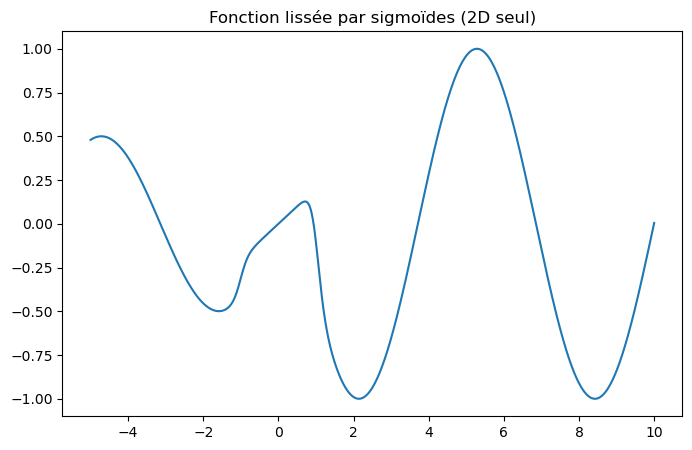

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(x, y)
plt.title("Fonction lissée par sigmoïdes (2D seul)")
plt.show()

In [5]:
slider = FloatSlider(value=140, min=0, max=360, step=.01, description='Rotation Z')
interact(plot_3d, angle_deg=slider)

interactive(children=(FloatSlider(value=140.0, description='Rotation Z', max=360.0, step=0.01), Output()), _do…

<function __main__.plot_3d(angle_deg=0)>

---